# FamTree
A Python program designed to build and display a family tree from a specially-formatted CSV file.

Made by [Bryan Luu](https://github.com/bryanluu)

## Libraries
The following Python libraries were used:
- `numpy` to process numerical data
- `pandas` to read in the CSV file
- `cairo` to draw the family tree in SVG format
- `io` for display in Jupyter
- `IPython` for display in Jupyter

In [1]:
import numpy as np
import pandas as pd
import cairo

from io import BytesIO
import IPython.display

Read in the family-tree data in CSV format, into variable `df`.

In [2]:
df = pd.read_csv("data/test.csv")

# convert to strings
df = df.astype(str)
# replace nans with blank string
df = df.applymap(lambda s: "" if s == "nan" else s)
# remove newlines
df = df.applymap(lambda s: s.rstrip('\n'))

# display data
df

,Full Name,Nickname,Year Born,Father,Mother,Spouse,Children
0,Mother,Mom,1969,Maternal Grandfather,Maternal Grandmother,Father,"Me, Brother, Sister"
1,Father,Dad,1965,Paternal Grandfather,Paternal Grandmother,Mother,"Me, Brother, Sister"
2,Me,,1994,Father,Mother,,
3,Sister,Sis,1990,Father,Mother,,
4,Brother,Bro,1998,Father,Mother,,
5,Paternal Grandfather,PGP,1938,,,Paternal Grandmother,"Father, Ben"
6,Paternal Grandmother,PGM,1940,,,Paternal Grandfather,"Father, Ben"
7,Maternal Grandfather,MGP,1941,,,Maternal Grandmother,"Mother, Sue"
8,Maternal Grandmother,MGM,1946,,,Maternal Grandfather,"Mother, Sue"
9,Ben,,1960,Paternal Grandfather,Paternal Grandmother,,


Define important variables. `V` is the number of vertices (family members). `di` is a dictionary mapping names to indices (-1 corresponds to a missing entry). `children` lists the number of children a node has, `parents` the number of parents, and `spouses` is a dictionary that links to the corresponding spouse (-1 if none).

In [13]:
# number of vertices
V = len(df)
# create index dictionary
di = dict()
for i in range(V):
    di[df["Full Name"][i]] = i
di[""] = -1

def getChildren(v):
    return list(map(lambda s: s.strip(), df.loc[v, "Children"].split(",")))

children = [0]*V
parents = [0]*V
spouses = {}

for v in range(V):
    c = getChildren(v)
    children[v] = (len(c) if c != [''] else 0)
    if di[df.loc[v, "Father"]] != -1:
        parents[v] += 1
    if di[df.loc[v, "Father"]] != -1:
        parents[v] += 1
    spouses[v] = int(di[df.loc[v, "Spouse"]])

print("Family members:", V)

Family members: 13


This function returns the height of a given node index. Leaf nodes have a height of -1. `down` is a variable which tells the function to measure height from the bottom or the top of the tree (bottom by default).

In [4]:
def height(node, down=True):
    if down:
        if children[node] == 0:
            return -1
        else:
            return max(height(e[1]) for e in E if e[0] == node) + 1
    else:
        if parents[node] == 0:
            return -1
        else:
            pa, ma = di[df.loc[node, "Father"]], di[df.loc[node, "Mother"]]
            return max(height(pa, down), height(ma, down)) + 1

This code organizes vertices by their age groups. `AGE_GAP` controls how close the consecutive ages must be in an age group. `i` sorts indices corresponding to age (oldest to youngest), `tw` gives the width of the widest age group, `W` is the width of the different age groups, and `K` is the age group numbers.

In [12]:
AGE_GAP = 10

# sort birth years
years = np.array([int(df.loc[v, "Year Born"]) for v in range(V)])
i = np.argsort(years)

# max tree width
tw = 0

# width at the given vertex's age group
W = np.ones(V, int)

# age group
k = 0
K = np.zeros(V, int) # age group array

# find age group and neighbors for each vertex
v = 0
while v < V-1:
#     print(years[i][v])
    
    vstart = v
    
    while(v+1 < V):
#         print(W[i])
        k = vstart
        # check if next birth is within age gap, add to width if it is
        if years[i][v+1] - years[i][v] < AGE_GAP:
            W[i[vstart:v+2]] = W[i[vstart]]
            K[i[vstart:v+2]] = k
            W[i[vstart:v+2]] += 1
            if W[i[vstart]] > tw:
                tw = W[i[vstart]]
            v += 1
        else:
            v += 1
            break

print("Vertices sorted by age:\n", df.loc[i, "Full Name"])
print("Neighbors:", W[i])
print("Age Groups:", K[i])

print("Tree Width:", tw)

Vertices sorted by age:
 5     Paternal Grandfather
6     Paternal Grandmother
7     Maternal Grandfather
8     Maternal Grandmother
9                      Ben
1                   Father
11                   Peter
0                   Mother
10                     Sue
3                   Sister
2                       Me
4                  Brother
12                  Cousin
Name: Full Name, dtype: object
Neighbors: [4 4 4 4 5 5 5 5 5 4 4 4 4]
Age Groups: [0 0 0 0 4 4 4 4 4 9 9 9 9]
Tree Width: 5


Draw the family tree into `test.svg`. 

Settings:
- `TREE_WIDTH` controls the width of the tree.
- `TREE_HEIGHT` controls the height of the tree.
- `WIDTH`, `HEIGHT` are the dimensions of the canvas.
- `NEIGHBOR_SPACING` controls how spaced out neighbors in the same age group are.
- `BORDER_SCALE` controls how large the border is for space.
- `FONT_SIZE` controls the size of labels' text.

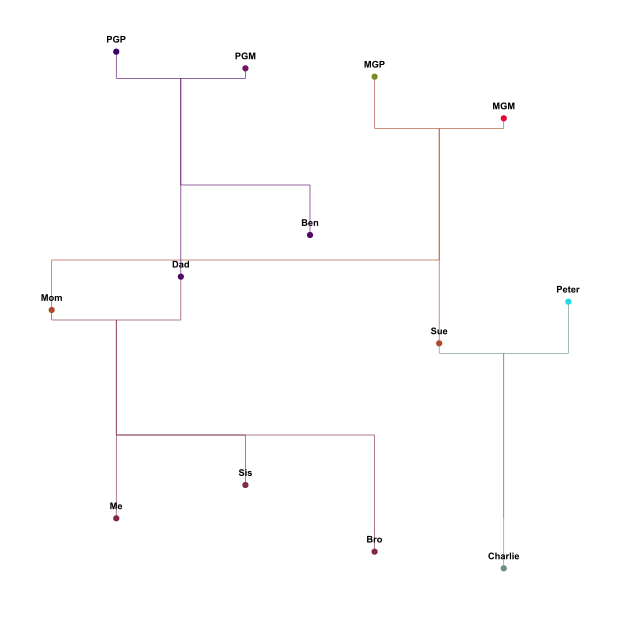

In [6]:
TREE_WIDTH = max(tw*100, (np.max(years) - np.min(years))*10)
TREE_HEIGHT = TREE_WIDTH
WIDTH, HEIGHT = TREE_WIDTH, TREE_HEIGHT
NEIGHBOR_SPACING = TREE_WIDTH/tw
BORDER_SCALE = 0.1
FONT_SIZE = 0.015

# Labels
labels = [df.loc[v, "Nickname"] if len(df.loc[v, "Nickname"]) > 0 else df.loc[v, "Full Name"] for v in range(V)]

# Vertex positions
vx = np.zeros(V)
vy = np.array([years[v] for v in range(V)])

# Get x position based on relative width compared to neighbors
X = np.arange(V)
for v in range(V):
    g = (K == K[v])
    if v > np.min(X[g]):
        continue
    else:
        for n in range(W[v]):
            vx[X[g][n]] = TREE_WIDTH/2 - NEIGHBOR_SPACING*W[v]/2 + n*NEIGHBOR_SPACING
            
# Normalize positions
mx, Mx = np.min(vx), np.max(vx)
my, My = np.min(vy), np.max(vy)
vx = (BORDER_SCALE*WIDTH + (vx - mx)/(Mx - mx)*WIDTH)/((1+2*BORDER_SCALE)*WIDTH)
vy = (BORDER_SCALE*HEIGHT + (vy - my)/(My - my)*HEIGHT)/((1+2*BORDER_SCALE)*HEIGHT)

# Vertex size
vr = 0.005

# Branch heights
top_branch = {-1:-1}
low_branch = {-1:-1}
for v in range(V):
    top_branch[v] = max(vy[v], vy[spouses[v]]) + 1/(My-my)
for v in range(V):
    low_branch[v] = min([vy[di[c]] for c in getChildren(v)]) - 5/(My-my)
    
# Node colors
colors = {-1:np.array([0,0,0])}
for v in range(V):
    if parents[i[v]] == 0:
        colors[i[v]] = np.random.random(3)
    else:
        pa = di[df.loc[i[v], "Father"]]
        ma = di[df.loc[i[v], "Mother"]]
        colors[i[v]] = (colors[pa]+colors[ma])/2

svgio = BytesIO()
with cairo.SVGSurface(svgio, WIDTH, HEIGHT) as surface:
    cr = cairo.Context(surface)

    cr.scale(WIDTH, HEIGHT)  # Normalizing the canvas
    
    for v in range(V):
        # if node has children, draw tree paths
        if children[v] > 0:
            # Draw joining line
            cr.set_source_rgb(*((colors[v]+colors[spouses[v]])/2))
            cr.move_to(vx[v], vy[v])
            cr.set_line_width(0.001)
            cr.line_to(vx[v], top_branch[v])
            cr.stroke()
            cr.move_to(vx[v], top_branch[v])
            cr.line_to((vx[v]+vx[spouses[v]])/2, top_branch[v])
            cr.stroke()
            
            # Draw line to children
            cr.move_to((vx[v]+vx[spouses[v]])/2, top_branch[v])
            cr.line_to((vx[v]+vx[spouses[v]])/2, low_branch[v])
            cr.stroke()
            
        if parents[v] > 0:
            # draw pre-connector branch
            cr.set_source_rgb(*colors[v])
            pa, ma = di[df.loc[v, "Father"]], di[df.loc[v, "Mother"]]
            cl = max(low_branch[pa], low_branch[ma])
            cr.move_to((vx[pa]+vx[ma])/2, cl)
            cr.line_to(vx[v], cl)
            cr.stroke()
            
            # draw node connection
            cr.set_line_width(0.001)
            cr.move_to(vx[v], cl)
            cr.line_to(vx[v], vy[v])
            cr.stroke()

        # Draw node
        cr.arc(vx[v], vy[v], vr, 0, 2*math.pi)
        cr.set_source_rgb(*colors[v])
        cr.fill()

        # Draw label
        cr.set_source_rgb(0, 0, 0)
        cr.select_font_face("Arial",
                cairo.FONT_SLANT_NORMAL, cairo.FONT_WEIGHT_BOLD)
        cr.set_font_size(0.015)
        _xbearing, _ybearing, _width, _height, _xadvance, _yadvance = (
                    cr.text_extents(labels[v]))
        cr.move_to(vx[v] - _xbearing - _width / 2,
                    vy[v] - 0.02 - _ybearing - _height / 2)
        cr.show_text(labels[v])
        
    
IPython.display.SVG(data=svgio.getvalue())

Draw the ancestry tree of `root` into `test2.svg`. 

Settings:
- `VERTICAL_SPACING` controls how the tree should stretch vertically.
- `TREE_WIDTH` controls the width of the tree.
- `TREE_HEIGHT` controls the height of the tree.
- `WIDTH`, `HEIGHT` are the dimensions of the canvas.
- `NEIGHBOR_SPACING` controls how spaced out neighbors in the same age group are.
- `BORDER_SCALE` controls how large the border is for space.
- `FONT_SIZE` controls the size of labels' text.

[300. 100. 200.   0.   0.  50. 150. 250. 350.   0.   0.   0.   0.] [200. 200. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


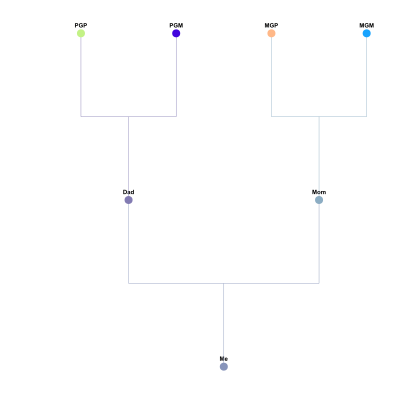

In [7]:
# Root variable
root = di["Me"]

# Ancestry Tree of root
VERTICAL_SPACING = 100
th = height(root, down=False)+1
tw = 2**th
md = max(tw, th)
TREE_WIDTH = md*VERTICAL_SPACING
TREE_HEIGHT = md*VERTICAL_SPACING
WIDTH, HEIGHT = TREE_WIDTH, TREE_HEIGHT
NEIGHBOR_SPACING = TREE_WIDTH/tw
BORDER_SCALE = 0.1
FONT_SIZE = 0.015

# Labels
labels = [df.loc[v, "Nickname"] if len(df.loc[v, "Nickname"]) > 0 else df.loc[v, "Full Name"] for v in range(V)]

# Vertex positions
vx = np.zeros(V)
vy = np.zeros(V)

# Set x position based on relative width compared to neighbors
def _ancestorSetXPos(v, lvl=1):
    if children[v] == 0:
        vx[v] = WIDTH/2
    
    pa, ma = di[df.loc[v, "Father"]], di[df.loc[v, "Mother"]]
    if(pa != -1):
        if(parents[v] == 1):
            vx[pa] = vx[v]
        else:
            vx[pa] = vx[v]-NEIGHBOR_SPACING*lvl
        _ancestorSetXPos(pa, lvl/2)
    if(ma != -1):
        if(parents[v] == 1):
            vx[ma] = vx[v]
        else:
            vx[ma] = vx[v]+NEIGHBOR_SPACING*lvl
        _ancestorSetXPos(ma, lvl/2)
    
# Set y position based on height:
def _ancestorSetYPos(v):
    if children[v] == 0:
        vy[v] = TREE_HEIGHT
    
    pa, ma = di[df.loc[v, "Father"]], di[df.loc[v, "Mother"]]
    if(pa != -1):
        vy[pa] = vy[v] - TREE_HEIGHT/th
        _ancestorSetYPos(pa)
    if(ma != -1):
        vy[ma] = vy[v] - TREE_HEIGHT/th
        _ancestorSetYPos(ma)
        
_ancestorSetXPos(root)
_ancestorSetYPos(root)

print(vx, vy)
            
# Normalize positions
mx, Mx = np.min(vx), np.max(vx)
my, My = np.min(vy), np.max(vy)
vx = (BORDER_SCALE*WIDTH + (vx - mx)/(Mx - mx)*WIDTH)/((1+2*BORDER_SCALE)*WIDTH)
vy = (BORDER_SCALE*HEIGHT + (vy - my)/(My - my)*HEIGHT)/((1+2*BORDER_SCALE)*HEIGHT)

# Vertex size
vr = 0.01

# Node colors
colors = {-1:np.array([0,0,0])}
for v in range(V):
    if parents[i[v]] == 0:
        colors[i[v]] = np.random.random(3)
    else:
        pa = di[df.loc[i[v], "Father"]]
        ma = di[df.loc[i[v], "Mother"]]
        colors[i[v]] = (colors[pa]+colors[ma])/2

svgio = BytesIO()
with cairo.SVGSurface(svgio, WIDTH, HEIGHT) as surface:
    cr = cairo.Context(surface)

    cr.scale(WIDTH, HEIGHT)  # Normalizing the canvas
    
    q = []
    
    q.append(root)
    
    while(len(q) > 0):
        v = q.pop(0)
        
        # Draw node
        cr.arc(vx[v], vy[v], vr, 0, 2*math.pi)
        cr.set_source_rgb(*colors[v])
        cr.fill()

        # Draw label
        cr.set_source_rgb(0, 0, 0)
        cr.select_font_face("Arial",
                cairo.FONT_SLANT_NORMAL, cairo.FONT_WEIGHT_BOLD)
        cr.set_font_size(0.015)
        _xbearing, _ybearing, _width, _height, _xadvance, _yadvance = (
                    cr.text_extents(labels[v]))
        cr.move_to(vx[v] - _xbearing - _width / 2,
                    vy[v] - 0.02 - _ybearing - _height / 2)
        cr.show_text(labels[v])
        
        
#         print("Nodes:", labels[v])
        
        pa, ma = di[df.loc[v, "Father"]], di[df.loc[v, "Mother"]]
        
        # Draw branches
        if(parents[v] > 0):
            cr.set_source_rgb(*colors[v])
            cr.move_to(vx[v], vy[v])
            cr.set_line_width(0.001)
            cr.line_to(vx[v], (vy[v] + max(vy[pa], vy[ma]))/2)
            cr.stroke()
            cr.move_to(vx[v], (vy[v] + max(vy[pa], vy[ma]))/2)
            cr.line_to(vx[pa], (vy[v] + max(vy[pa], vy[ma]))/2)
            cr.stroke()
            cr.move_to(vx[pa], (vy[v] + max(vy[pa], vy[ma]))/2)
            cr.line_to(vx[pa], vy[pa])
            cr.stroke()
            cr.move_to(vx[v], (vy[v] + max(vy[pa], vy[ma]))/2)
            cr.line_to(vx[ma], (vy[v] + max(vy[pa], vy[ma]))/2)
            cr.stroke()
            cr.move_to(vx[ma], (vy[v] + max(vy[pa], vy[ma]))/2)
            cr.line_to(vx[ma], vy[ma])
            cr.stroke()
            if pa != -1:
                q.append(pa)
            if ma != -1:
                q.append(ma)
    
IPython.display.SVG(data=svgio.getvalue())